# Description

Use bid-ask data to analyze and simulate trading execution quality.

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.plotting as coplotti
import core.statistics as costatis
import dataflow.core as dtfcore 
import dataflow.pipelines.execution.execution_pipeline as dtfpexexpi
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im_v2.common.data.client.im_raw_data_client as imvcdcimrdc
import im_v2.common.universe.universe_utils as imvcuunut
import oms
import oms.ccxt_filled_orders_reader as ocfiorre

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-66bfa50d-f288-495c-91b5-1cdb919da3b5.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4277_Add_bid_ask_execution_notebook'
  hash='c5c06b230'
  # Last commits:
    * c5c06b230 Daniil Tikhomirov Cm task4238 open positions and total balance (#4258)              (    3 days ago) Fri Apr 21 17:08:42 2023  (HEAD -> CmTask4277_Add_bid_ask_execution_notebook, origin/master, origin/HEAD, master)
    * 2ae793e5b Daniil Tikhomirov CMTask4254: Fix  incorrect sleeptime calculation (#4268)          (    3 days ago) 

# Config

In [3]:
system_log_dir = "/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230419/system_log_dir.scheduled.20230419_041000.20230419_100500"
bar_duration = "5T"
id_col = "asset_id"

In [4]:
ccxt_log_reader = ocfiorre.CcxtLogsReader(system_log_dir)

In [5]:
btc_usdt_id = 1467591036

In [6]:
use_historical = True

# Load order responses and fills

In [7]:
ccxt_order_response_df = ccxt_log_reader.load_ccxt_order_response_df()
fills_df = ccxt_log_reader.load_ccxt_fills_df()

Loading `/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230419/system_log_dir.scheduled.…

Loading `/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230419/system_log_dir.scheduled.…

In [8]:
trade_prices = ocfiorre.compute_buy_sell_prices_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)

In [9]:
child_order_df = ccxt_log_reader.load_child_order_df()

Loading `/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230419/system_log_dir.scheduled.…

# Load bid-ask data

In [10]:
# TODO(Paul): Refine the cuts around the first and last bars.
start_timestamp = ccxt_order_response_df["order_response_datetime"].min()
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = fills_df["datetime"].max()
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2023-04-19 04:10:38.554000+00:00
INFO  end_timestamp=2023-04-19 08:04:47.291000+00:00


In [11]:
def load_bid_ask_data(
    start_timestamp,
    end_timestamp,
    use_historical,
    asset_ids,
) -> pd.DataFrame:
    if use_historical:
        signature = "periodic_daily.airflow.downloaded_1sec.parquet.bid_ask.futures.v3.crypto_chassis.binance.v1_0_0"
        reader = imvcdcimrdc.RawDataReader(signature)
    else:
        signature = "realtime.airflow.downloaded_200ms.postgres.bid_ask.futures.v7.ccxt.binance.v1_0_0"
        reader = imvcdcimrdc.RawDataReader(signature)
    bad = reader.read_data(start_timestamp, end_timestamp)
    hdbg.dassert(not bad.empty, "Requested bid-ask data not available.")
    #
    currency_pair_to_full_symbol = {
        x: "binance::" + x for x in bad["currency_pair"].unique()
    }
    asset_id_to_full_symbol = imvcuunut.build_numerical_to_string_id_mapping(
        currency_pair_to_full_symbol.values()
    )
    full_symbol_mapping_to_asset_id = {
        v: k for k, v in asset_id_to_full_symbol.items()
    }
    currency_pair_to_asset_id = {
        x: full_symbol_mapping_to_asset_id[currency_pair_to_full_symbol[x]]
        for x in bad["currency_pair"].unique()
    }
    # Add asset_ids
    list(currency_pair_to_asset_id.values())
    bad_asset_id = bad["currency_pair"].apply(
        lambda x: currency_pair_to_asset_id[x]
    )
    bad["asset_id"] = bad_asset_id
    #
    if asset_ids is not None:
        bad = bad[bad["asset_id"].isin(asset_ids)]
    if not use_historical:
        bad = bad[
            ["bid_price_l1", "ask_price_l1", "asset_id", "knowledge_timestamp"]
        ].rename(
            columns={"bid_price_l1": "bid_price", "ask_price_l1": "ask_price"},
        )
        bad = bad.pivot_table(columns=["asset_id"], index="knowledge_timestamp")
    else:
        bad = bad[
            ["bid_price_l1", "ask_price_l1", "asset_id"]
        ].rename(
            columns={"bid_price_l1": "bid_price", "ask_price_l1": "ask_price"},
        )
        bad = bad.pivot(columns=["asset_id"])
    bad.index = bad.index.ceil("1s")
    bad = bad.resample("1s").mean().ffill()
    # if use_historical:
    #     bad.index.tz_localize("utc")
    return bad

In [12]:
bad = load_bid_ask_data(
    start_timestamp,
    end_timestamp,
    use_historical,
    trade_prices.columns.levels[1],
)

INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3
INFO  Loading dataset schema file: /app/amp/data_schema/dataset_schema_versions/dataset_schema_v3.json
INFO  Loaded dataset schema version v3


In [13]:
bad.head()

bid_price                                                                    ask_price                                                                  
asset_id                  1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878 1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878
timestamp                                                                                                                                                                          
2023-04-19 04:10:38+00:00    2086.76    30169.1      6.839     24.588    0.09293      0.527     340.95    2086.77    30169.2       6.84     24.589    0.09294     0.5271     340.96
2023-04-19 04:10:39+00:00    2086.76    30169.1      6.839     24.588    0.09293      0.527     340.95    2086.77    30169.2       6.84     24.589    0.09294     0.5271     340.96
2023-04-19 04:10:40+00:00    2086.76    30167.1      6.839     24.588    0.09294      0.527     340.95    2086.77    30167.2       6.84     24.589    0.09295     0.5271     340.96
2023-04-19 04:10:41+00:00    2086.76    30167.1      6.839     24.588    0.09295      0.527     340.95    2086.77    30167.2       6.84     24.589    0.09296     0.5271     340.96
2023-04-19 04:10:42+00:00    2086.76    30167.1      6.839     24.588    0.09295      0.527     340.95    2086.77    30167.2       6.84     24.589    0.09296     0.5271     340.96

# Replay limit orders and simulate trades

- Use actual limit prices seen in actual execution
- Simulate execution using actual limit prices and bid-ask data
- Compare simulated execution to actual execution

## Extract the actual limit orders

In [14]:
bad.columns.levels[1]

Int64Index([1464553467, 1467591036, 1891737434, 2237530510, 3065029174, 5118394986, 8968126878], dtype='int64', name='asset_id')

In [15]:
child_order_df_restricted = child_order_df[child_order_df["asset_id"].isin(bad.columns.levels[1])]

In [16]:
child_order_df_restricted.head()

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,limit_price,ccxt_id
order_id,,,,,,,,,,,,,,,,,,
27,2023-04-19 04:10:47.923610+00:00,8968126878,limit,2023-04-19 04:10:47.923610+00:00,2023-04-19 04:11:47.923610+00:00,0.0,-0.180,America/New_York,{'ccxt_id': 46213170767},0.55,341.1900,341.2000,341.216429,341.226429,latest_bid_price,latest_ask_price,341.195500,46213170767
28,2023-04-19 04:10:50.685245+00:00,1467591036,limit,2023-04-19 04:10:50.685245+00:00,2023-04-19 04:11:50.685245+00:00,0.0,-0.004,America/New_York,{'ccxt_id': 141434849632},0.55,30180.5000,30180.6000,30181.244186,30181.344186,latest_bid_price,latest_ask_price,30180.555000,141434849632
31,2023-04-19 04:10:57.955213+00:00,1891737434,limit,2023-04-19 04:10:57.955213+00:00,2023-04-19 04:11:57.955213+00:00,0.0,-5.500,America/New_York,{'ccxt_id': 18425602980},0.55,6.8440,6.8450,6.844878,6.845878,latest_bid_price,latest_ask_price,6.844550,18425602980
33,2023-04-19 04:11:01.996567+00:00,1464553467,limit,2023-04-19 04:11:01.996567+00:00,2023-04-19 04:12:01.996567+00:00,0.0,0.005,America/New_York,{'ccxt_id': 8389765593301032146},0.55,2087.7500,2087.7600,2088.150000,2088.160000,latest_bid_price,latest_ask_price,2087.754500,8389765593301032146
44,2023-04-19 04:11:22.024649+00:00,5118394986,limit,2023-04-19 04:11:22.024649+00:00,2023-04-19 04:12:22.024649+00:00,0.0,-18.100,America/New_York,{'ccxt_id': 32624473645},0.55,0.5276,0.5277,0.527667,0.527767,latest_bid_price,latest_ask_price,0.527655,32624473645


In [17]:
# Forward fill to represent the time-in-force of the underlying order
limit_prices = ocfiorre.get_limit_order_price(child_order_df_restricted)

# limit_prices.index = limit_prices.index.tz_localize("UTC")
limit_prices.head()

buy_limit_order_price                                                                   sell_limit_order_price                                                                  
asset_id                             1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878             1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878
creation_timestamp                                                                                                                                                                                        
2023-04-19 04:10:48+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN   341.1955
2023-04-19 04:10:49+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:10:50+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:10:51+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN  30180.555        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:10:52+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN

In [18]:
buy_order_num = np.sign(limit_prices["buy_limit_order_price"]).abs().cumsum()
sell_order_num = np.sign(limit_prices["sell_limit_order_price"]).abs().cumsum()

In [19]:
limit_prices = pd.concat({
    "buy_limit_order_price": limit_prices["buy_limit_order_price"],
    "sell_limit_order_price": limit_prices["sell_limit_order_price"],
    "buy_order_num": buy_order_num,
    "sell_order_num": sell_order_num,
}, axis=1).ffill(limit=59)

## Join limit orders with bid-ask data and simulate trades

In [20]:
# TODO(Paul): Historical bid/ask data needs to be lagged 1 minute
#  to properly align. May be due to beginning-of-bar vs end-of-bar
#. timestamp conventions.
in_df = pd.concat([limit_prices, bad.shift(60)], axis=1)
in_df.head()

buy_limit_order_price                                                                   sell_limit_order_price                                                                   buy_order_num                                                                   sell_order_num                                                                    bid_price                                                                    ask_price                                                                  
asset_id                             1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878             1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878    1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878     1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878 1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878 1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878
2023-04-19 04:10:38+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN            NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:10:39+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN            NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:10:40+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN            NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:10:41+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN            NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:10:42+00:00                   NaN        NaN        NaN        NaN        NaN        NaN        NaN                    NaN        NaN        NaN        NaN        NaN        NaN        NaN           NaN        NaN        NaN        NaN        NaN        NaN        NaN            NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN

In [21]:
node = dtfcore.GroupedColDfToDfTransformer(
    "estimate_limit_order_execution",
    transformer_func=cofinanc.estimate_limit_order_execution,
    **{
        "in_col_groups": [
            ("bid_price",),
            ("ask_price",),
            ("buy_limit_order_price",),
            ("sell_limit_order_price",),
            ("buy_order_num",),
            ("sell_order_num",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "bid_col": "bid_price",
            "ask_col": "ask_price",
            "buy_limit_price_col": "buy_limit_order_price",
            "sell_limit_price_col": "sell_limit_order_price",
            "buy_order_num_col": "buy_order_num",
            "sell_order_num_col": "sell_order_num",
        },
    },
)

In [22]:
simulated_execution_df = node.fit(in_df)["df_out"]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [23]:
simulated_execution_df.columns.levels[0].to_list()

['ask_price',
 'bid_price',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_price',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_price']

In [24]:
btc_exec = oms.get_asset_slice(simulated_execution_df, btc_usdt_id)

In [25]:
btc_exec.loc[~btc_exec["buy_trade_price"].isna()][["buy_trade_price", "buy_limit_order_price", "buy_order_num", "bid_price", "ask_price"]]

,buy_trade_price,buy_limit_order_price,buy_order_num,bid_price,ask_price
2023-04-19 04:15:57+00:00,30165.445,30165.445,1.0,30161.0,30161.1
2023-04-19 04:17:15+00:00,30144.545,30144.545,2.0,30141.4,30141.6
2023-04-19 04:36:43+00:00,30203.345,30203.345,5.0,30203.0,30203.1
2023-04-19 04:38:06+00:00,30200.145,30200.745,7.0,30199.0,30199.1
2023-04-19 04:38:07+00:00,30199.1,30200.745,7.0,30197.2,30197.3
2023-04-19 04:39:07+00:00,30208.0,30210.445,8.0,30207.9,30208.0
2023-04-19 04:46:03+00:00,30205.345,30205.345,9.0,30202.3,30202.4
2023-04-19 04:48:00+00:00,30180.345,30180.345,10.0,30180.0,30180.1
2023-04-19 04:48:07+00:00,30171.6,30177.545,11.0,30171.5,30171.6
2023-04-19 04:49:24+00:00,30168.845,30168.845,12.0,30167.7,30167.8


In [26]:
simulated_execution_df["buy_trade_price"].resample(
    "5T", closed="right", label="right"
).mean()

,1464553467,1467591036,1891737434,2237530510,3065029174,5118394986,8968126878
2023-04-19 04:15:00+00:00,2086.753625,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:20:00+00:00,2085.591167,30154.995000,NaN,NaN,NaN,0.527200,340.680000
2023-04-19 04:25:00+00:00,NaN,NaN,6.854117,NaN,NaN,NaN,340.793625
2023-04-19 04:30:00+00:00,NaN,NaN,6.856967,24.623950,NaN,NaN,NaN
2023-04-19 04:35:00+00:00,NaN,NaN,6.855225,24.613725,0.093172,0.528397,340.572250
2023-04-19 04:40:00+00:00,2088.325875,30202.647500,NaN,NaN,0.093225,NaN,NaN
2023-04-19 04:45:00+00:00,NaN,NaN,6.862950,24.633225,NaN,0.528800,NaN
2023-04-19 04:50:00+00:00,2087.560875,30181.533750,6.862588,24.625613,NaN,0.528886,340.578625
2023-04-19 04:55:00+00:00,NaN,NaN,6.859837,NaN,NaN,NaN,340.562250
2023-04-19 05:00:00+00:00,2084.454500,30177.995000,6.854000,NaN,0.093405,NaN,NaN


In [27]:
active_cols = ["buy_limit_order_price", "buy_trade_price"] 

In [28]:
btc_slice = oms.get_asset_slice(simulated_execution_df, btc_usdt_id)

<AxesSubplot: >

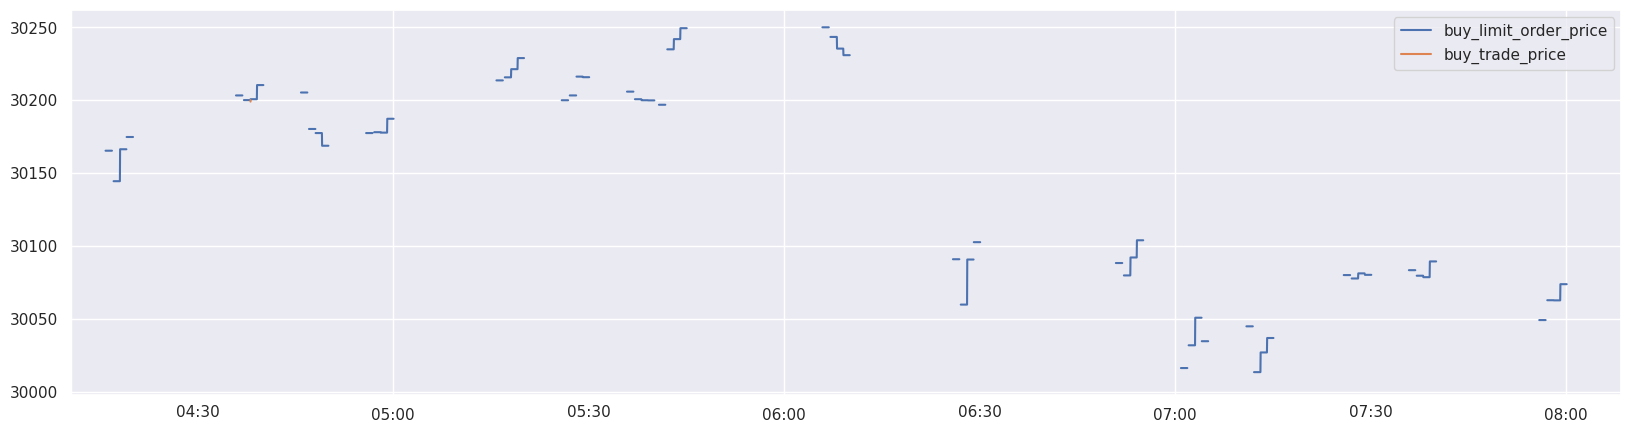

In [29]:
btc_slice[active_cols].plot()

<AxesSubplot: >

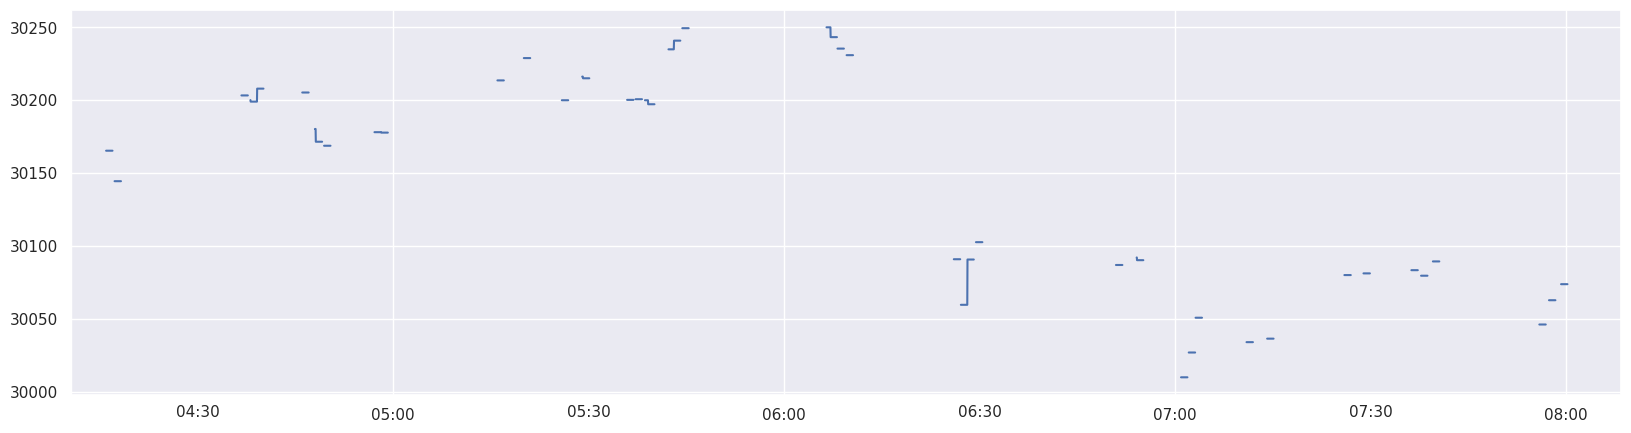

In [30]:
btc_slice["buy_trade_price"].ffill(limit=59).plot()

## Compute simulated trade execution quality against bid-ask benchmarks

In [31]:
simulated_execution_quality_node = dtfcore.GroupedColDfToDfTransformer(
    "simulated_execution_quality",
    transformer_func=cofinanc.compute_execution_quality,
    **{
        "in_col_groups": [
            ("buy_trade_price",),
            ("sell_trade_price",),
            ("bid_price",),
            ("ask_price",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "bid_col": "bid_price",
            "ask_col": "ask_price",
            "buy_trade_price_col": "buy_trade_price",
            "sell_trade_price_col": "sell_trade_price",
        },
    },
)

In [32]:
simulated_execution_quality_df = simulated_execution_quality_node.fit(
    simulated_execution_df
)["df_out"]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [33]:
simulated_execution_quality_df.columns.levels[0].to_list()

['ask_price',
 'bid_ask_midpoint',
 'bid_price',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_midpoint_slippage_bps',
 'buy_trade_midpoint_slippage_notional',
 'buy_trade_price',
 'buy_trade_price_improvement_bps',
 'buy_trade_price_improvement_notional',
 'buy_trade_price_improvement_spread_pct',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_midpoint_slippage_bps',
 'sell_trade_midpoint_slippage_notional',
 'sell_trade_price',
 'sell_trade_price_improvement_bps',
 'sell_trade_price_improvement_notional',
 'sell_trade_price_improvement_spread_pct',
 'spread_bps',
 'spread_notional']

In [34]:
active_cols = ["buy_limit_order_price", "buy_trade_price"]

In [35]:
btc_slice = oms.get_asset_slice(simulated_execution_quality_df, btc_usdt_id)

In [36]:
btc_slice[active_cols].dropna(how="all")

,buy_limit_order_price,buy_trade_price
2023-04-19 04:15:52+00:00,30165.445,NaN
2023-04-19 04:15:53+00:00,30165.445,NaN
2023-04-19 04:15:54+00:00,30165.445,NaN
2023-04-19 04:15:55+00:00,30165.445,NaN
2023-04-19 04:15:56+00:00,30165.445,NaN
...,...,...
2023-04-19 08:00:01+00:00,30073.945,NaN
2023-04-19 08:00:02+00:00,30073.945,NaN
2023-04-19 08:00:03+00:00,30073.945,NaN
2023-04-19 08:00:04+00:00,30073.945,NaN


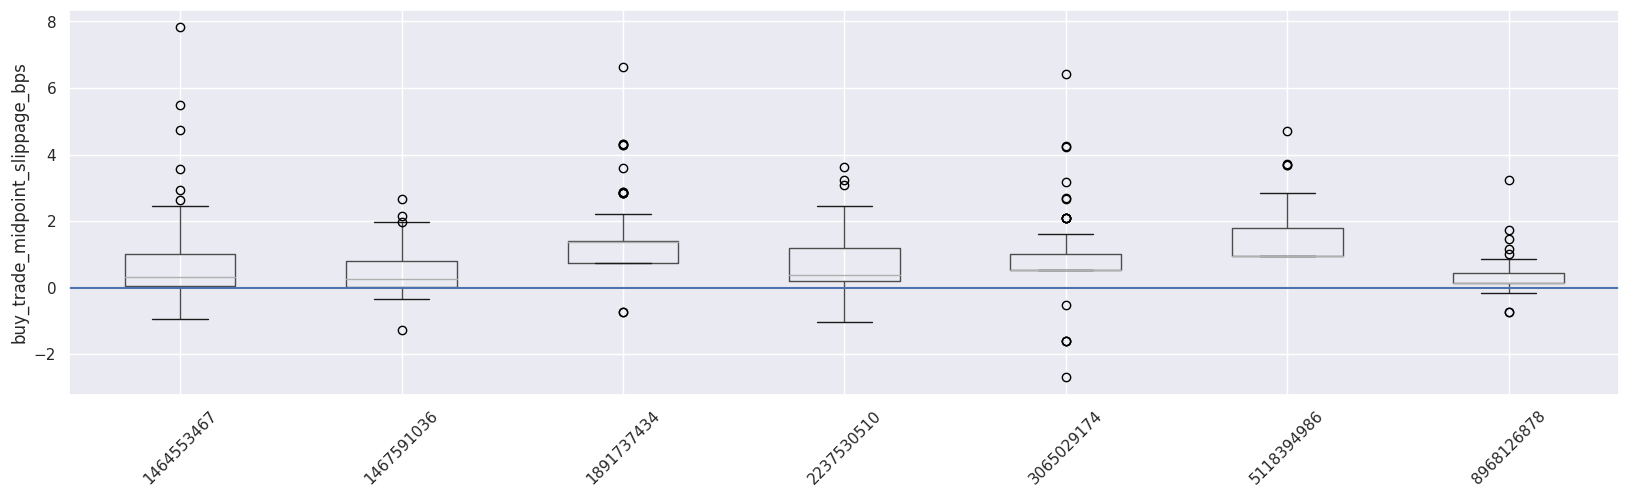

In [37]:
col = "buy_trade_midpoint_slippage_bps"
coplotti.plot_slippage_boxplot(
    simulated_execution_quality_df[col], "by_asset", ylabel=col
)

<AxesSubplot: >

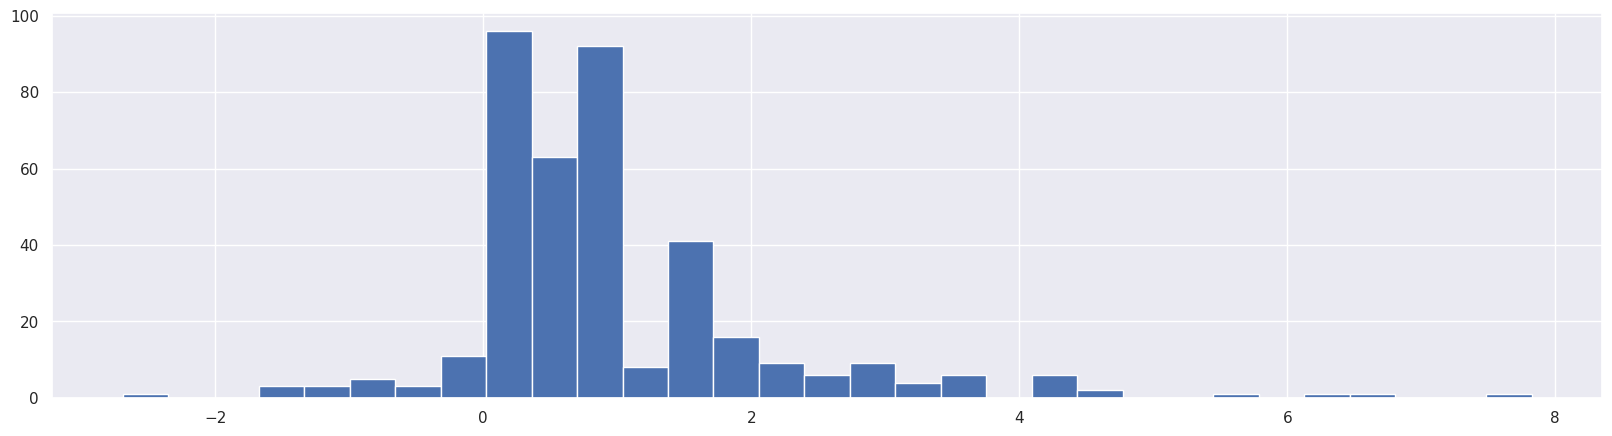

In [38]:
simulated_execution_quality_df["buy_trade_midpoint_slippage_bps"].unstack().hist(
    bins=31
)

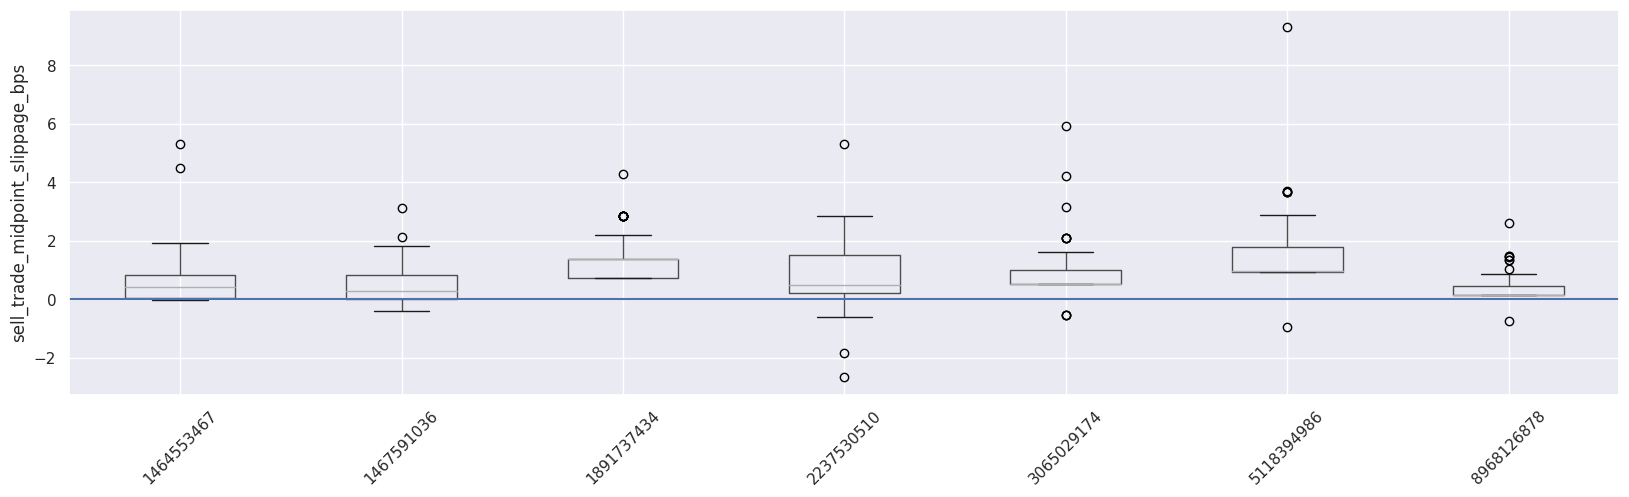

In [39]:
col = "sell_trade_midpoint_slippage_bps"
coplotti.plot_slippage_boxplot(
    simulated_execution_quality_df[col], "by_asset", ylabel=col
)

<AxesSubplot: >

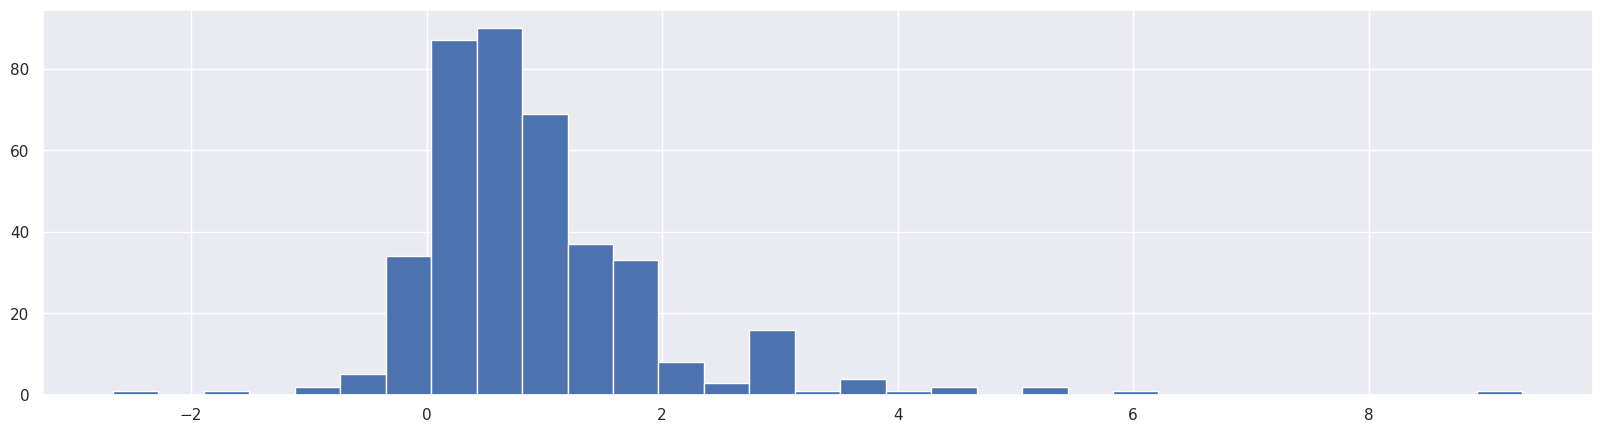

In [40]:
simulated_execution_quality_df["sell_trade_midpoint_slippage_bps"].unstack().hist(
    bins=31
)

In [41]:
costatis.compute_moments(
    simulated_execution_quality_df["buy_trade_midpoint_slippage_bps"].unstack()
)

mean        0.940950
std         1.165397
skew        1.903922
kurtosis    6.621444
dtype: float64

In [42]:
costatis.compute_moments(simulated_execution_quality_df["spread_bps"].unstack())

mean        0.745681
std         0.682256
skew        0.497323
kurtosis   -1.283396
dtype: float64

## Compare actual trade prices to simulated trade prices

In [43]:
actual_vs_sim_trade_price_resampling_freq = "1T"

In [44]:
# The "8s" is an empirically-derived estimate of order delay.
simulated_execution_df["sell_limit_order_price"].resample(
    actual_vs_sim_trade_price_resampling_freq, closed="right", label="right", offset="8s"
).mean().head()

,1464553467,1467591036,1891737434,2237530510,3065029174,5118394986,8968126878
2023-04-19 04:11:08+00:00,NaN,30180.555,6.844550,NaN,NaN,NaN,341.195500
2023-04-19 04:12:08+00:00,NaN,30180.555,6.844550,NaN,NaN,0.527655,341.195500
2023-04-19 04:13:08+00:00,NaN,30177.855,6.842550,NaN,NaN,0.527330,340.955500
2023-04-19 04:14:08+00:00,NaN,30170.350,6.842550,NaN,NaN,0.527245,340.916167
2023-04-19 04:15:08+00:00,NaN,30165.585,6.843417,NaN,NaN,0.527310,340.827000


In [45]:
trade_prices = ocfiorre.compute_buy_sell_prices_by_bar(
    fills_df, actual_vs_sim_trade_price_resampling_freq, offset="8s", groupby_id_col="asset_id"
)
trade_prices.head()

buy_trade_price                                                                                                                                                                                                                                                                         sell_trade_price                                                                                                                                                                                                                                                                        
asset_id                       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2023-04-19 04:11:08+00:00             NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     0.8321        NaN      4.457        NaN        NaN        NaN              NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:12:08+00:00             NaN    2087.65        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN      8.509     1.1696        NaN      3.134     0.6931        NaN        NaN        NaN        NaN        NaN        NaN              NaN        NaN        NaN        NaN      5.621        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN
2023-04-19 04:13:08+00:00             NaN    2086.64        NaN        NaN        NaN        NaN        NaN      1.670        NaN        NaN        NaN        NaN        NaN        NaN      8.503     1.1690        NaN      3.132     0.6926     0.8318        NaN      4.456        NaN        NaN        NaN              NaN        NaN        NaN        NaN        NaN      6.843        NaN        NaN        NaN     2.2941        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN    0.52720        NaN        NaN        NaN      2.331
2023-04-19 04:14:08+00:00             NaN    2085.61        NaN        NaN        NaN        NaN        NaN      1.669        NaN        NaN        NaN        NaN        NaN        NaN      8.506     1.1692        NaN      3.130     0.6928        NaN        NaN      4.456        NaN        NaN        NaN              NaN        NaN        NaN        NaN      5.622      6.843        NaN        NaN        NaN     2.2946        NaN        NaN        NaN        NaN        NaN        NaN        NaN      

In [46]:
resampled_simulated_execution_df = simulated_execution_df.resample(
    actual_vs_sim_trade_price_resampling_freq, closed="right", label="right", offset="8s",
).mean()
resampled_simulated_execution_df.head()

buy_trade_price                                                                   limit_buy_executed                                                                   limit_sell_executed                                                                   sell_trade_price                                                                   buy_limit_order_price                                                                   sell_limit_order_price                                                                    buy_order_num                                                                   sell_order_num                                                                      bid_price                                                                          ask_price                                                                      
                               1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878         1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878          1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878       1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878            1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878             1464553467 1467591036 1891737434 2237530510 3065029174 5118394986  8968126878    1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878     1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878   1464553467    1467591036 1891737434 2237530510 3065029174 5118394986  8968126878   1464553467    1467591036 1891737434 2237530510 3065029174 5118394986  8968126878
2023-04-19 04:11:08+00:00             NaN        NaN        NaN        NaN        NaN        NaN        NaN           0.000000        0.0        0.0        0.0        0.0        0.0        0.0                 0.0        0.0   0.000000        0.0        0.0   0.000000        0.0              NaN        NaN        NaN        NaN        NaN        NaN        NaN           2087.754500        NaN        NaN        NaN        NaN        NaN        NaN                    NaN  30180.555   6.844550        NaN        NaN        NaN  341.195500      1.000000        NaN        NaN        NaN        NaN        NaN        NaN            NaN       1.00   1.000000        NaN        NaN        NaN   1.000000          NaN           NaN        NaN        NaN        NaN        NaN         NaN          NaN           NaN        NaN        NaN        NaN        NaN         NaN
2023-04-19 04:12:08+00:00       2087.7545        NaN        NaN        NaN        NaN        NaN        NaN           0.016667        0.0        0.0        0.0        0.0        0.0        0.0                 0.0        0.0   0.000000        0.0        0.0   0.000000        0.0              NaN        NaN        NaN        NaN        NaN        NaN        NaN           2087.754500        NaN        NaN        NaN        NaN        NaN        NaN                    NaN  30180.555   6.844550        NaN        NaN   0.527655  341.195500      1.000000        NaN        NaN        NaN        NaN        NaN        NaN            NaN       1.00   1.000000        NaN        NaN       1.00   1.000000  2087.352581  30172.261290   6.840355  24.593387   0.092980   0.527035  340.950000  2087.362581  30172.361290   6.841355  24.594387   0.092990   0.527135  340.960000
2023-04-19 04:13:08+00:00       2086.8600        NaN        NaN        NaN        NaN        NaN        NaN           0.016667        0.0        0.0        0.0        0.0        0.0        0.0                 0.0        0.0   0.000000        0.0        0.0   0.016667        0.0              NaN        NaN        NaN        NaN        NaN     0.5272        NaN           2087.764500        NaN        NaN        NaN        NaN        NaN        NaN                    NaN  30177.855   6.842550        NaN        NaN   0.527330  340.955500      2.000000     

In [47]:
actual_trade_prices = ocfiorre.compute_buy_sell_prices_by_bar(
    fills_df, "1s", offset="0s", groupby_id_col="asset_id"
)

In [48]:
def combine_sim_and_actual_trades(simulated_execution_df, fills, freq, offset):
    #
    actual_trade_prices = ocfiorre.compute_buy_sell_prices_by_bar(
        fills, freq, offset=offset, groupby_id_col="asset_id",
    )
    resampled_simulated_execution_df = simulated_execution_df.resample(
        freq, closed="right", label="right", offset=offset,
    ).mean()
    #
    col_set = actual_trade_prices.columns.levels[1].union(
        resampled_simulated_execution_df.columns.levels[1]
    )
    col_set = col_set.sort_values()
    #
    trade_price_dict = {
        "actual_buy_trade_price": actual_trade_prices["buy_trade_price"].reindex(
            columns=col_set
        ),
        "actual_sell_trade_price": actual_trade_prices[
            "sell_trade_price"
        ].reindex(columns=col_set),
        "simulated_buy_trade_price": resampled_simulated_execution_df[
            "buy_trade_price"
        ].reindex(columns=col_set),
        "simulated_sell_trade_price": resampled_simulated_execution_df[
            "sell_trade_price"
        ].reindex(columns=col_set),
    }
    simulated_and_actual_trade_price_df = pd.concat(trade_price_dict, axis=1)
    return simulated_and_actual_trade_price_df

In [49]:
actual_vs_sim_trade_price_resampling_freq = "5T"

In [50]:
simulated_and_actual_trade_price_df = combine_sim_and_actual_trades(
    simulated_execution_df,
    fills_df,
    actual_vs_sim_trade_price_resampling_freq,
    offset="8s",
)
simulated_and_actual_trade_price_df.head()

actual_buy_trade_price                                                                                                                                                                                                                                                                            actual_sell_trade_price                                                                                                                                                                                                                                                                         simulated_buy_trade_price                                                                                                                                                                                                                                                                            simulated_sell_trade_price                                                                      \
                                      1030828978   1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573              1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                1030828978   1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573                 1030828978   1464553467 1467591036 1528092593 1776791608 1891737434 1966583502   
2023-04-19 04:15:08+00:00                    NaN  2086.633333        NaN   0.226000        NaN        NaN        NaN   1.669667        NaN        NaN        NaN        NaN        NaN        NaN      8.506   1.169267        NaN      3.132   0.692833    0.83195        NaN   4.456333        NaN         NaN        NaN                0.393750        NaN   30165.40        NaN   5.622667   6.844333   0.525800        NaN        NaN   2.294600        NaN        NaN        NaN    9.29000        NaN        NaN        NaN        NaN        NaN        NaN    0.52730        NaN     20.996     340.83   2.331333                       NaN  2086.753625        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN                        NaN          NaN        NaN        NaN        NaN    6.84305        NaN   
2023-04-19 04:20:08+00:00                    NaN  2081.970000    30136.9   0.225467        NaN        NaN        NaN        NaN        NaN        NaN        NaN   1.061000    0.13360    9.28100        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     20.977  340.760000      2.332                0.393533        NaN        NaN        NaN   5.624500        NaN   0.526133     1.6690     24.619        NaN   0.401033        NaN        NaN        NaN        NaN        NaN   0.093132   3.134667   0.692667   0.832275        NaN   4.458667        NaN        NaN        NaN                       NaN  2085.591167  30154.995        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN   0.527200        NaN        NaN  340.680000        NaN                        NaN          NaN        NaN        NaN        NaN        NaN        NaN   
2023-04-19 04:25:08+00:00               0.3937

In [51]:
oms.get_asset_slice(simulated_and_actual_trade_price_df, btc_usdt_id)[["actual_buy_trade_price", "simulated_buy_trade_price"]].dropna(how="all")

,actual_buy_trade_price,simulated_buy_trade_price
2023-04-19 04:20:08+00:00,30136.900000,30154.995000
2023-04-19 04:40:08+00:00,30199.900000,30202.647500
2023-04-19 04:50:08+00:00,30174.775000,30181.533750
2023-04-19 05:00:08+00:00,30177.700000,30177.995000
2023-04-19 05:20:08+00:00,30227.500000,30221.295000
2023-04-19 05:30:08+00:00,30215.100000,30210.463333
2023-04-19 05:40:08+00:00,30198.800000,30199.597500
2023-04-19 05:45:08+00:00,NaN,30241.760000
2023-04-19 06:10:08+00:00,30235.950000,30239.933750
2023-04-19 06:30:08+00:00,30070.500000,30086.108750


In [52]:
oms.get_asset_slice(simulated_and_actual_trade_price_df, btc_usdt_id)[["actual_sell_trade_price", "simulated_sell_trade_price"]].dropna(how="all")

,actual_sell_trade_price,simulated_sell_trade_price
2023-04-19 04:15:08+00:00,30165.400000,NaN
2023-04-19 04:25:08+00:00,30172.050000,30181.450000
2023-04-19 04:35:08+00:00,NaN,30215.005000
2023-04-19 04:45:08+00:00,30208.850000,30206.555000
2023-04-19 05:05:08+00:00,30193.400000,30189.455000
2023-04-19 05:10:08+00:00,30183.800000,NaN
2023-04-19 05:15:08+00:00,30204.700000,30204.770000
2023-04-19 05:25:08+00:00,30217.566667,30216.605000
2023-04-19 05:35:08+00:00,30206.650000,30205.805000
2023-04-19 05:50:08+00:00,30298.550000,30289.070000


In [53]:
execution_quality_node = dtfcore.GroupedColDfToDfTransformer(
    "execution_quality",
    transformer_func=ocfiorre.compute_execution_quality,
    **{
        "in_col_groups": [
            ("actual_buy_trade_price",),
            ("actual_sell_trade_price",),
            ("simulated_buy_trade_price",),
            ("simulated_sell_trade_price",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "buy_trade_reference_price_col": "simulated_buy_trade_price",
            "sell_trade_reference_price_col": "simulated_sell_trade_price",
            "buy_trade_price_col": "actual_buy_trade_price",
            "sell_trade_price_col": "actual_sell_trade_price",
        },
    },
)

In [54]:
sim_vs_actual_execution_quality_df = execution_quality_node.fit(
    simulated_and_actual_trade_price_df
)["df_out"]

In [55]:
sim_vs_actual_execution_quality_df.columns.levels[0].to_list()

['actual_buy_trade_price',
 'actual_sell_trade_price',
 'buy_trade_slippage_bps',
 'buy_trade_slippage_notional',
 'sell_trade_slippage_bps',
 'sell_trade_slippage_notional',
 'simulated_buy_trade_price',
 'simulated_sell_trade_price']

In [56]:
oms.get_asset_slice(sim_vs_actual_execution_quality_df, btc_usdt_id)

,buy_trade_slippage_bps,buy_trade_slippage_notional,sell_trade_slippage_bps,sell_trade_slippage_notional,actual_buy_trade_price,actual_sell_trade_price,simulated_buy_trade_price,simulated_sell_trade_price
2023-04-19 04:15:08+00:00,NaN,NaN,NaN,NaN,NaN,30165.400000,NaN,NaN
2023-04-19 04:20:08+00:00,-6.000664,-18.095000,NaN,NaN,30136.900000,NaN,30154.995000,NaN
2023-04-19 04:25:08+00:00,NaN,NaN,3.114496,9.400000,NaN,30172.050000,NaN,30181.450000
2023-04-19 04:30:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:35:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30215.005000
2023-04-19 04:40:08+00:00,-0.909688,-2.747500,NaN,NaN,30199.900000,NaN,30202.647500,NaN
2023-04-19 04:45:08+00:00,NaN,NaN,-0.759769,-2.295000,NaN,30208.850000,NaN,30206.555000
2023-04-19 04:50:08+00:00,-2.239366,-6.758750,NaN,NaN,30174.775000,NaN,30181.533750,NaN
2023-04-19 04:55:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 05:00:08+00:00,-0.097753,-0.295000,NaN,NaN,30177.700000,NaN,30177.995000,NaN


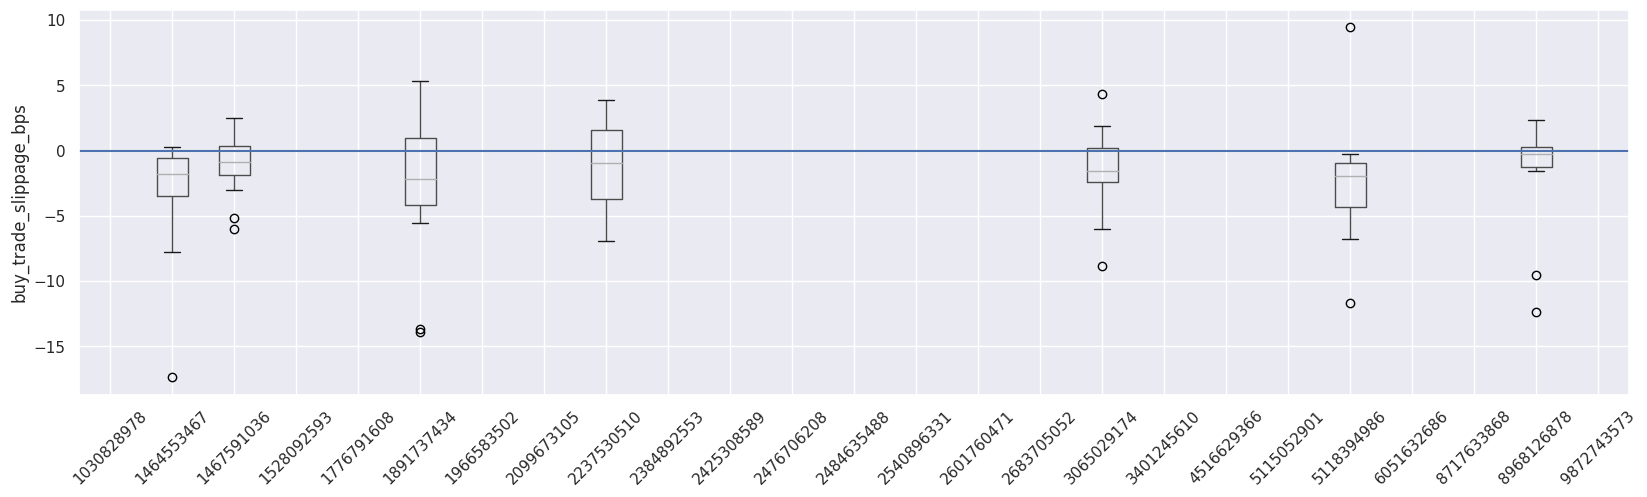

In [57]:
col = "buy_trade_slippage_bps"
coplotti.plot_slippage_boxplot(
    sim_vs_actual_execution_quality_df[col], "by_asset", ylabel=col
)

<AxesSubplot: >

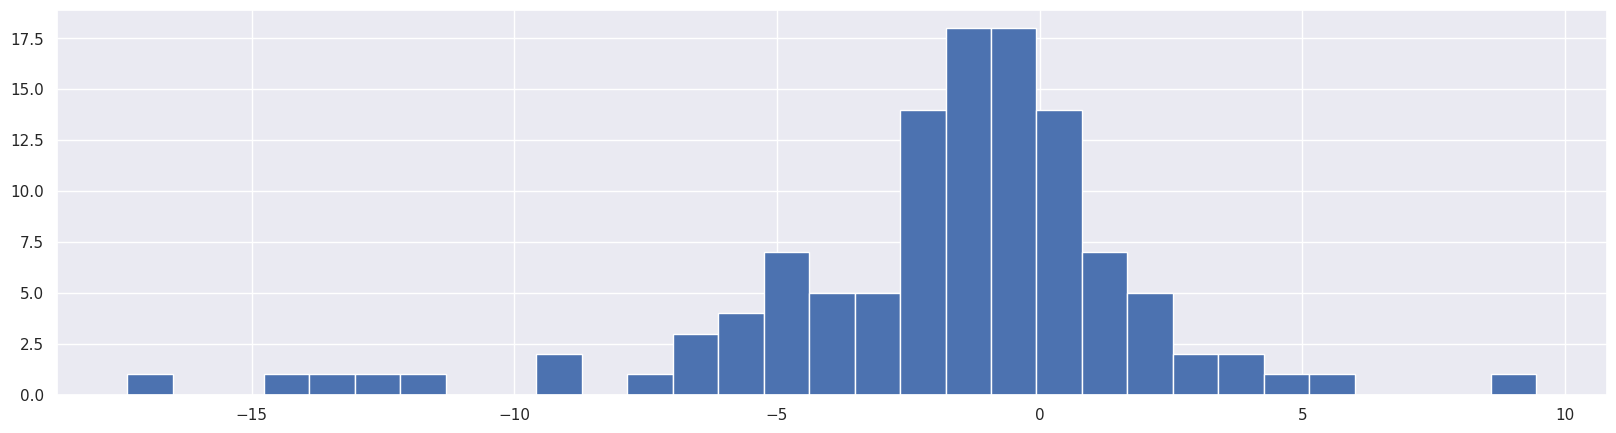

In [58]:
sim_vs_actual_execution_quality_df["buy_trade_slippage_bps"].unstack().hist(
    bins=31
)

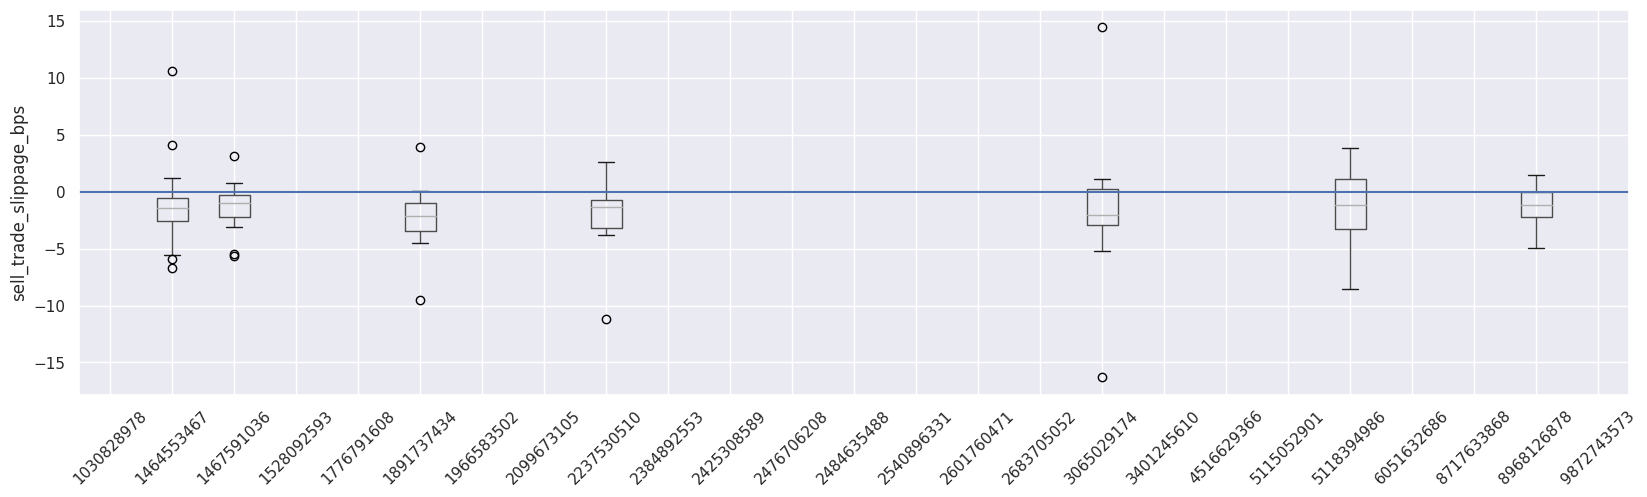

In [59]:
col = "sell_trade_slippage_bps"
coplotti.plot_slippage_boxplot(
    sim_vs_actual_execution_quality_df[col], "by_asset", ylabel=col
)

<AxesSubplot: >

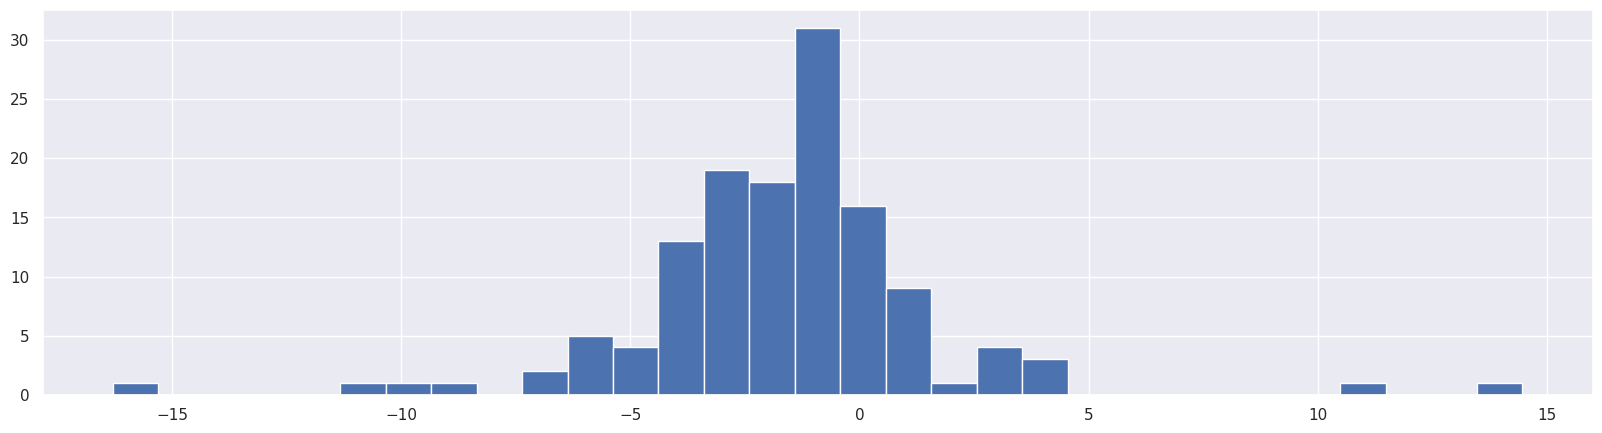

In [60]:
sim_vs_actual_execution_quality_df["sell_trade_slippage_bps"].unstack().hist(
    bins=31
)

# Simulate limit order generation and trades

- Specify buy/sell aggressiveness parameters
- Specify repricing frequency and time-in-force
- Simulate average execution prices and percentage of bars filled

In [61]:
def get_data():
    # Shift historical 60 seconds (bar convention)
    return bad.shift(60)

In [62]:
dag_builder = dtfpexexpi.ExecutionPipeline()
#
config = dag_builder.get_config_template()
# Set up `overwrite` mode to allow reassignment of values.
# Note: by default the `update_mode` does not allow overwrites,
# but they are required by the FeaturePipeline.
config.update_mode = "overwrite"
_LOG.debug("config from dag_builder=%s", config)
# Initialize config.
config["load_data"] = cconfig.Config.from_dict(
    {
        "source_node_name": "FunctionDataSource",
        "source_node_kwargs": {
            "func": get_data,
        },
    }
)
config["resample", "transformer_kwargs", "rule"] = "1T"
config["resample", "transformer_kwargs", "resample_kwargs", "offset"] = "8s"
config[
    "generate_limit_orders", "transformer_kwargs", "buy_spread_frac_offset"
] = 0.45
config[
    "generate_limit_orders", "transformer_kwargs", "sell_spread_frac_offset"
] = -0.45
config["generate_limit_orders", "transformer_kwargs", "subsample_freq"] = "60s"
config["generate_limit_orders", "transformer_kwargs", "freq_offset"] = "9s"
config["generate_limit_orders", "transformer_kwargs", "ffill_limit"] = 59

#
_LOG.debug("config after patching=%s", config)
dag = dag_builder.get_dag(config)

In [63]:
bid_ask_sim_flow_df = dag.run_leq_node("compute_trade_vs_limit_execution_quality", "fit")["df_out"]

run_leq_node:   0%|          | 0/5 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values
/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [64]:
bid_ask_sim_flow_df.columns.levels[0].to_list()

['ask_price',
 'bid_ask_midpoint',
 'bid_price',
 'buy_limit_order_price',
 'buy_order_num',
 'buy_trade_limit_slippage_bps',
 'buy_trade_limit_slippage_notional',
 'buy_trade_midpoint_slippage_bps',
 'buy_trade_midpoint_slippage_notional',
 'buy_trade_price',
 'buy_trade_price_improvement_bps',
 'buy_trade_price_improvement_notional',
 'buy_trade_price_improvement_spread_pct',
 'limit_buy_executed',
 'limit_sell_executed',
 'sell_limit_order_price',
 'sell_order_num',
 'sell_trade_limit_slippage_bps',
 'sell_trade_limit_slippage_notional',
 'sell_trade_midpoint_slippage_bps',
 'sell_trade_midpoint_slippage_notional',
 'sell_trade_price',
 'sell_trade_price_improvement_bps',
 'sell_trade_price_improvement_notional',
 'sell_trade_price_improvement_spread_pct',
 'spread_bps',
 'spread_notional']

In [65]:
btc_df = oms.get_asset_slice(bid_ask_sim_flow_df, btc_usdt_id)

In [66]:
btc_df[["bid_price", "ask_price", "buy_order_num", "buy_trade_price", "buy_limit_order_price"]]

,bid_price,ask_price,buy_order_num,buy_trade_price,buy_limit_order_price
timestamp,,,,,
2023-04-19 04:11:08+00:00,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:12:08+00:00,30172.261290,30172.361290,NaN,NaN,NaN
2023-04-19 04:13:08+00:00,30169.165000,30169.265000,1.0,30172.845,30172.845
2023-04-19 04:14:08+00:00,30163.818333,30163.918333,2.0,30169.945,30169.945
2023-04-19 04:15:08+00:00,30159.850000,30159.950000,3.0,30160.145,30160.145
2023-04-19 04:16:08+00:00,30163.841667,30163.943333,4.0,30160.045,30160.045
2023-04-19 04:17:08+00:00,30143.851667,30143.953333,5.0,30157.045,30157.045
2023-04-19 04:18:08+00:00,30156.356667,30156.458333,6.0,30149.945,30149.945
2023-04-19 04:19:08+00:00,30172.641667,30172.741667,7.0,NaN,30169.445


In [67]:
bid_ask_sim_flow_df.head()

buy_trade_limit_slippage_bps                                                                         buy_trade_limit_slippage_notional                                                                         sell_trade_limit_slippage_bps                                                                   sell_trade_limit_slippage_notional                                                                   bid_ask_midpoint                                                                       buy_trade_midpoint_slippage_bps                                                                   buy_trade_midpoint_slippage_notional                                                                   buy_trade_price_improvement_bps                                                                      buy_trade_price_improvement_notional                                                                      buy_trade_price_improvement_spread_pct                             \
                                            1464553467    1467591036 1891737434    2237530510 3065029174 5118394986 8968126878                        1464553467    1467591036 1891737434    2237530510 3065029174 5118394986 8968126878                    1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878                         1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878       1464553467    1467591036 1891737434 2237530510 3065029174 5118394986  8968126878                      1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878                           1464553467 1467591036 1891737434 2237530510 3065029174 5118394986 8968126878                      1464553467 1467591036    1891737434 2237530510 3065029174 5118394986 8968126878                           1464553467 1467591036    1891737434 2237530510 3065029174 5118394986 8968126878                             1464553467   1467591036    1891737434   
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2023-04-19 04:11:08+00:00                          NaN           NaN        NaN           NaN        NaN        NaN        NaN                               NaN           NaN        NaN           NaN        NaN        NaN        NaN                           NaN        NaN        NaN        NaN        NaN        NaN        NaN                                NaN        NaN        NaN        NaN        NaN        NaN        NaN              NaN           NaN        NaN        NaN        NaN        NaN         NaN                             NaN        NaN        NaN        NaN        NaN        NaN        NaN                                  NaN        NaN        NaN        NaN        NaN        NaN        NaN                             NaN        NaN           NaN        NaN        NaN        NaN        NaN                                  NaN        NaN           NaN        NaN        NaN        NaN        NaN                                    NaN          NaN           NaN   
2023-04-19 04:12:08+00:00                         

<AxesSubplot: xlabel='timestamp'>

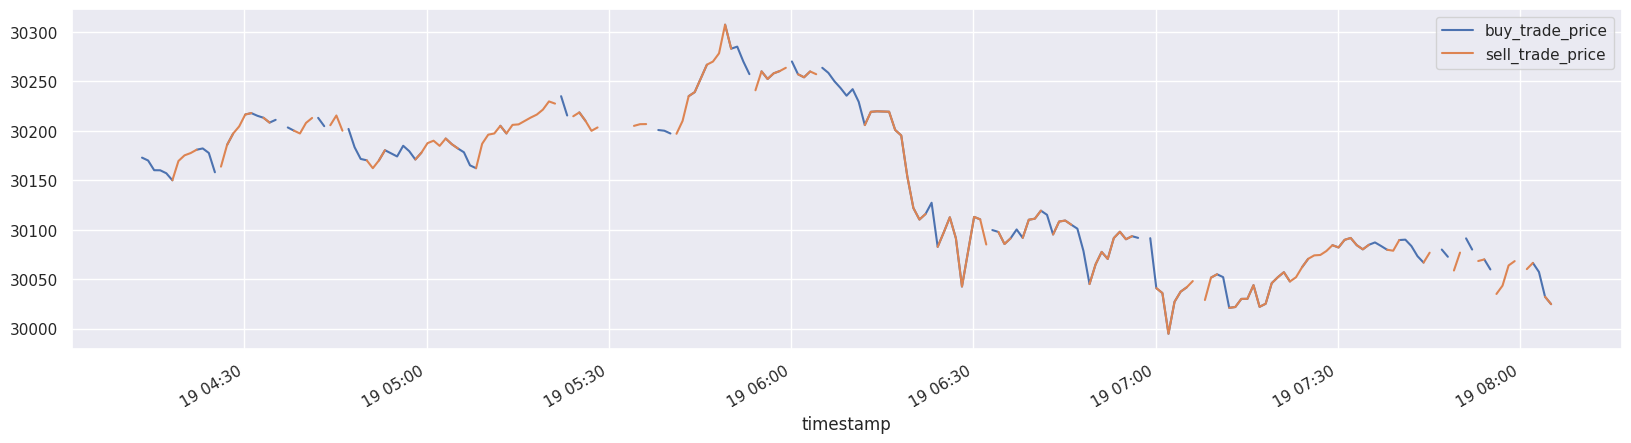

In [68]:
oms.get_asset_slice(bid_ask_sim_flow_df, btc_usdt_id)[
    ["buy_trade_price", "sell_trade_price"]
].plot()

In [69]:
oms.get_asset_slice(bid_ask_sim_flow_df, btc_usdt_id).head()

,buy_trade_limit_slippage_bps,buy_trade_limit_slippage_notional,sell_trade_limit_slippage_bps,sell_trade_limit_slippage_notional,bid_ask_midpoint,buy_trade_midpoint_slippage_bps,buy_trade_midpoint_slippage_notional,buy_trade_price_improvement_bps,buy_trade_price_improvement_notional,buy_trade_price_improvement_spread_pct,sell_trade_midpoint_slippage_bps,sell_trade_midpoint_slippage_notional,sell_trade_price_improvement_bps,sell_trade_price_improvement_notional,sell_trade_price_improvement_spread_pct,spread_bps,spread_notional,ask_price,bid_price,buy_limit_order_price,buy_order_num,buy_trade_price,limit_buy_executed,limit_sell_executed,sell_limit_order_price,sell_order_num,sell_trade_price
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-19 04:11:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN
2023-04-19 04:12:08+00:00,NaN,NaN,NaN,NaN,30172.311290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033143,0.1,30172.361290,30172.261290,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN
2023-04-19 04:13:08+00:00,-1.205713e-12,-3.637979e-12,NaN,NaN,30169.215000,1.203213,3.630000,-1.186638,-3.580000,-3580.000000,NaN,NaN,NaN,NaN,NaN,0.033146,0.1,30169.265000,30169.165000,30172.845,1.0,30172.845,0.016667,0.0,30172.855,1.0,NaN
2023-04-19 04:14:08+00:00,0.000000e+00,0.000000e+00,NaN,NaN,30163.868333,2.014552,6.076667,-1.997972,-6.026667,-6026.666667,NaN,NaN,NaN,NaN,NaN,0.033152,0.1,30163.918333,30163.818333,30169.945,2.0,30169.945,0.016667,0.0,30169.955,2.0,NaN
2023-04-19 04:15:08+00:00,0.000000e+00,0.000000e+00,NaN,NaN,30159.900000,0.081234,0.245000,-0.064655,-0.195000,-195.000000,NaN,NaN,NaN,NaN,NaN,0.033157,0.1,30159.950000,30159.850000,30160.145,3.0,30160.145,0.016667,0.0,30160.155,3.0,NaN


In [70]:
btc_simulated_prices = oms.get_asset_slice(bid_ask_sim_flow_df, btc_usdt_id)

In [71]:
active_cols = ["buy_limit_order_price", "buy_trade_price"]

<AxesSubplot: xlabel='timestamp'>

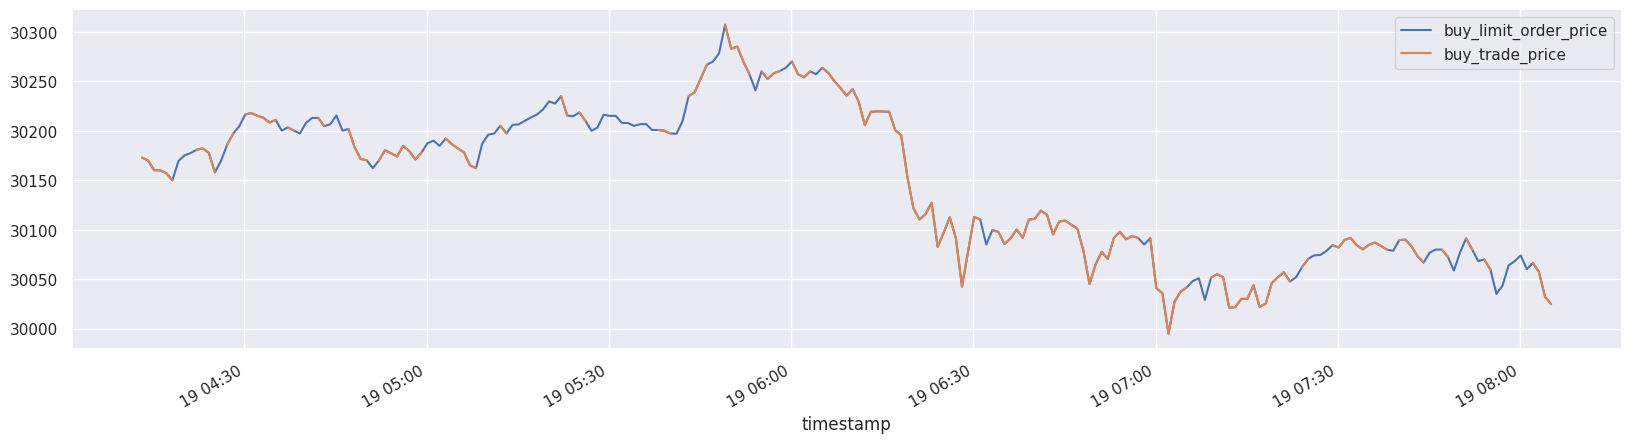

In [72]:
btc_simulated_prices[active_cols].dropna(how="all").plot()

In [73]:
# col = "buy_trade_midpoint_slippage_bps"
# coplotti.plot_slippage_boxplot(df_out[col], "by_time", ylabel=col)

In [74]:
# col = "sell_trade_midpoint_slippage_bps"
# coplotti.plot_slippage_boxplot(df_out[col], "by_time", ylabel=col)

In [75]:
costatis.compute_moments(bid_ask_sim_flow_df["buy_trade_limit_slippage_bps"].unstack())

mean           0.003353
std            0.114299
skew          34.189738
kurtosis    1166.958985
dtype: float64

In [76]:
costatis.compute_moments(bid_ask_sim_flow_df["sell_trade_limit_slippage_bps"].unstack())

mean           0.001874
std            0.055844
skew          33.022308
kurtosis    1109.366068
dtype: float64

# Compare simulated limit orders and actual limit orders

In [77]:
simulated_buy_limits = bid_ask_sim_flow_df["buy_limit_order_price"]

In [78]:
simulated_buy_limits.head()

,1464553467,1467591036,1891737434,2237530510,3065029174,5118394986,8968126878
timestamp,,,,,,,
2023-04-19 04:11:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:12:08+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:13:08+00:00,2087.3645,30172.845,6.84245,24.59745,0.093004,0.527145,340.9545
2023-04-19 04:14:08+00:00,2087.0345,30169.945,6.84245,24.60745,0.093025,0.527345,340.9145
2023-04-19 04:15:08+00:00,2085.6045,30160.145,6.84245,24.59445,0.093004,0.527245,340.8245


In [79]:
actual_buy_limits = in_df["buy_limit_order_price"]

In [80]:
actual_buy_limits.head()

asset_id,1464553467,1467591036,1891737434,2237530510,3065029174,5118394986,8968126878
2023-04-19 04:10:38+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:10:39+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:10:40+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:10:41+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-19 04:10:42+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
lim_vs_lim = pd.concat(
{
    "simulated_buy_limit": simulated_buy_limits,
    "actual_buy_limit": actual_buy_limits.resample("1T", offset="8s", closed="right", label="right").mean(),
}, axis=1)

In [82]:
lim_vs_lim.columns.levels[1]

Int64Index([1464553467, 1467591036, 1891737434, 2237530510, 3065029174, 5118394986, 8968126878], dtype='int64')

<AxesSubplot: >

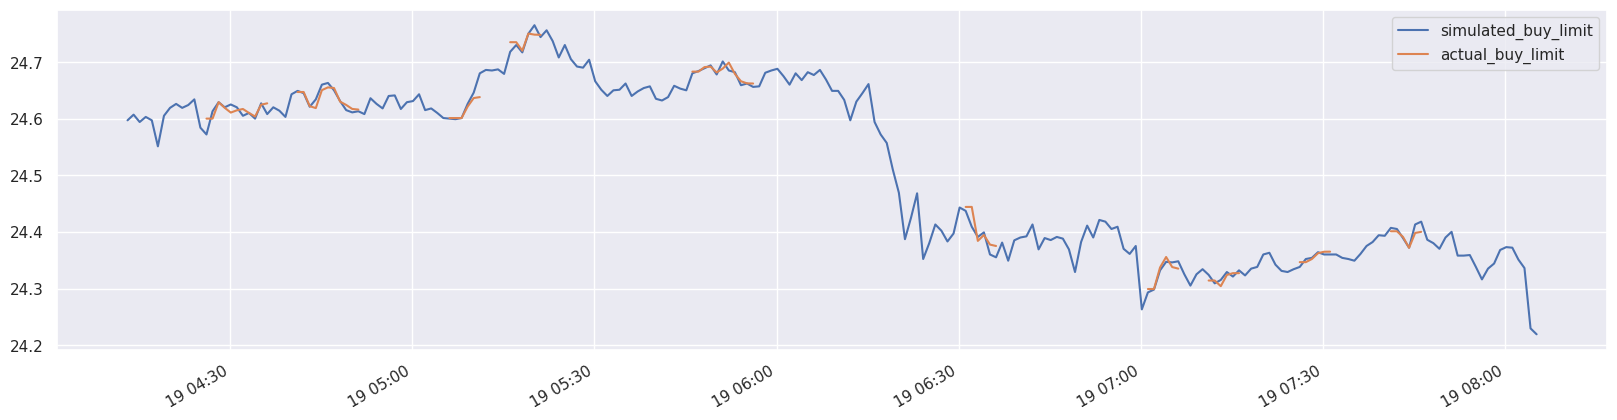

In [83]:
oms.get_asset_slice(lim_vs_lim, lim_vs_lim.columns.levels[1][3]).dropna(how="all").plot()

<AxesSubplot: >

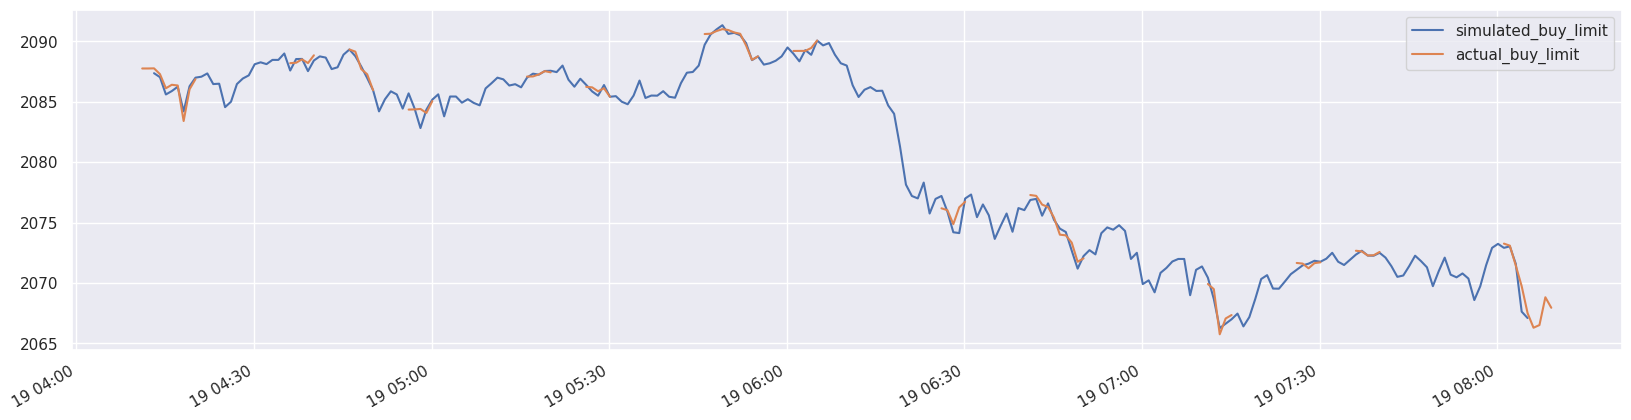

In [84]:
oms.get_asset_slice(lim_vs_lim, lim_vs_lim.columns.levels[1][0]).dropna(how="all").plot()